In [1]:
%matplotlib inline

# Analysis of An $AR(1)$ Model in pyMC3

Consider the following AR(1) process, initialized in the
infinite past:
$$
   y_t = \theta y_{t-1} + \epsilon_t,
$$
where $\epsilon_t \sim iid{\cal N}(0,1)$.  Suppose you'd like to learn about $\theta$ from a a sample of observations $Y^T = \{ y_0, y_1,\ldots, y_T \}$.

First, let's generate our sample.

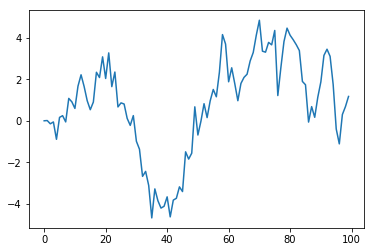

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(seed=1848)

T = 100
y = np.zeros((T,))

for i in range(1,T):
    y[i] = 0.95 * y[i-1] + np.random.normal()

plt.plot(y);

Consider the following prior for $\theta$: $\theta \sim {\cal N}(0,\tau^2)$.
We can show that the posterior distribution of $\theta$ is of the form

$$
 \theta |Y^T \sim {\cal N}( \tilde{\theta}_T, \tilde{V}_T),
$$

where

$$
\begin{eqnarray}
        \tilde{\theta}_T &=& \left( \sum_{t=1}^T y_{t-1}^2 + \tau^{-2} \right)^{-1} \sum_{t=1}^T y_{t}y_{t-1} \\
        \tilde{V}_T      &=& \left( \sum_{t=1}^T y_{t-1}^2 + \tau^{-2} \right)^{-1}
\end{eqnarray}
$$

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 146.18:   5%|▍         | 9054/200000 [00:00<00:12, 15100.19it/s]
Convergence archived at 9700
Interrupted at 9,700 [4%]: Average Loss = 222.3
100%|██████████| 1500/1500 [00:00<00:00, 2316.42it/s]


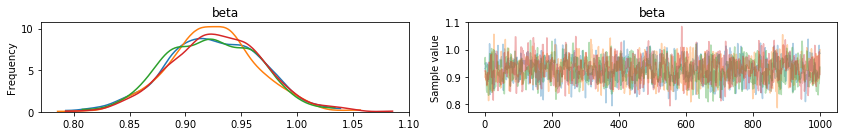

In [3]:
import pymc3 as pm


tau = 1.0
with pm.Model() as ar1:
    beta = pm.Normal('beta', mu=0, sd=tau)
    data = pm.AR('y', beta, sd=1.0, observed=y)
    trace = pm.sample(1000, njobs=4)
    
pm.traceplot(trace);

In [4]:
mup = ((y[:-1]**2).sum() + tau**-2)**-1 * np.dot(y[:-1],y[1:])
Vp =  ((y[:-1]**2).sum() + tau**-2)**-1
print('Mean: {:5.3f} (exact = {:5.3f})'.format(trace['beta'].mean(), mup))
print('Std: {:5.3f} (exact = {:5.3f})'.format(trace['beta'].std(), np.sqrt(Vp)))

Mean: 0.925 (exact = 0.925)
Std: 0.040 (exact = 0.040)


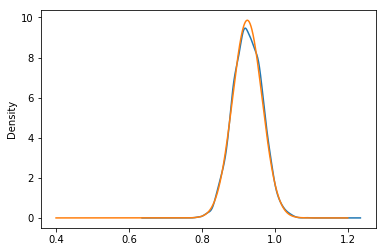

In [5]:
import pandas as p
from scipy.stats import norm
ax=p.Series(trace['beta']).plot(kind='kde')
xgrid = np.linspace(0.4, 1.2, 1000)
fgrid = norm(loc=mup, scale=np.sqrt(Vp)).pdf(xgrid)
ax.plot(xgrid,fgrid);

## Extension to AR(p)
We can instead estimate an AR(2) model using pyMC3.
$$
 y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t.
$$
The `AR` distribution infers the order of the process by size the of `rho` argmument passed to `AR`. 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 164.21:   5%|▍         | 9136/200000 [00:00<00:12, 15333.83it/s]
Convergence archived at 10500
Interrupted at 10,500 [5%]: Average Loss = 261.27
100%|██████████| 1500/1500 [00:01<00:00, 991.69it/s] 


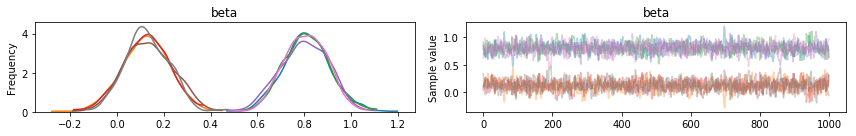

In [6]:
with pm.Model() as ar2:
    beta = pm.Normal('beta', mu=0, sd=tau, shape=2)
    data = pm.AR('y', beta, sd=1.0, observed=y)
    trace = pm.sample(1000, njobs=4)
    
pm.traceplot(trace);

You can also pass the set of AR parameters as a list. 

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 143.06:   7%|▋         | 14293/200000 [00:01<00:14, 13171.73it/s]
Convergence archived at 15500
Interrupted at 15,500 [7%]: Average Loss = 178.97
100%|██████████| 1500/1500 [00:01<00:00, 987.98it/s] 
/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.660117966551, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


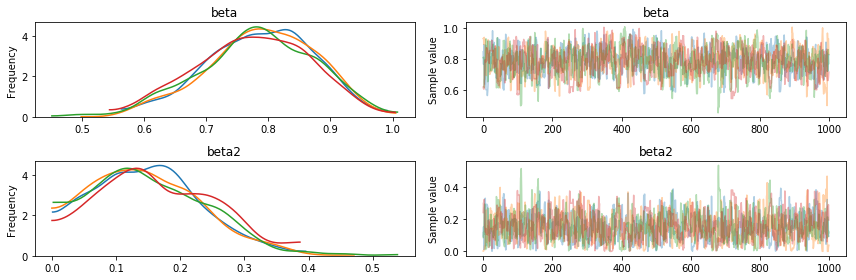

In [7]:
with pm.Model() as ar2:
    beta = pm.Normal('beta', mu=0, sd=tau)
    beta2 = pm.Uniform('beta2')
    data = pm.AR('y', [beta, beta2], sd=1.0, observed=y)
    trace = pm.sample(1000, njobs=4)
    
pm.traceplot(trace);